# 中文版 Ordered Prompts 实验（Entropy-based Prompt Ordering）

本 notebook 目标：在中文情感分类任务上，从零实现一版 “Entropy-based Ordered Prompts” 实验。

核心步骤：

1. 使用 `lansinuote/ChnSentiCorp` 中文情感数据集（二分类：0=负面，1=正面）。
2. 使用 `uer/gpt2-medium-chinese-cluecorpussmall` 作为中文 GPT-2 语言模型。
3. 从训练集中选 2 条正面 + 2 条负面作为 few-shot 示例（共 4 条）。
4. 枚举这 4 条的所有排列（4! = 24 个 prompt 顺序），每个顺序视为一个“候选 prompt”。
5. 对每个 prompt 顺序：
   - 在 probe 集上算平均预测分布，计算熵（entropy）；
   - 在 eval 集上算分类准确率（accuracy）。
6. 用 probe 熵排序选出 Top-K 个 prompt 顺序，对比：
   - baseline：所有 prompt 顺序准确率的平均；
   - ours：Top-K prompt 顺序准确率的平均。


In [ ]:
# 如果在 Colab 中，请先安装依赖
# （本地环境已经装过就可以注释掉）
!pip install -q transformers datasets accelerate sentencepiece

import math
import numpy as np
from itertools import permutations

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

# ----- Basic config -----
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "uer/gpt2-medium-chinese-cluecorpussmall"

# number of examples
n_shot = 4          # few-shot examples (2 pos + 2 neg)
n_probe = 16        # probe set size (for entropy)
n_eval = 128        # eval set size (for accuracy)

# limit comment length in tokens (avoid long context)
max_comment_tokens = 190

# random seeds
np.random.seed(1)
torch.manual_seed(1)

print(f"Device: {device}")


Device: cuda


In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

print("Tokenizer and model loaded.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

Tokenizer and model loaded.


In [ ]:
# Load Chinese sentiment dataset
dataset = load_dataset("lansinuote/ChnSentiCorp")

train_ds = dataset["train"]
test_ds = dataset["test"]  # we will build probe / eval from this split

print(train_ds)
print(test_ds[:3])


dataset_infos.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

data/train-00000-of-00001-02f200ca5f2a78(…):   0%|          | 0.00/2.16M [00:00<?, ?B/s]

data/validation-00000-of-00001-405befbaa(…):   0%|          | 0.00/276k [00:00<?, ?B/s]

data/test-00000-of-00001-5372924f059fe76(…):   0%|          | 0.00/275k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})
{'text': ['这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般', '怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片！开始还怀疑是不是赠送的个别现象，可是后来发现每张DVD后面都有！真不知道生产商怎么想的，我想看的是猫和老鼠，不是米老鼠！如果厂家是想赠送的话，那就全套米老鼠和唐老鸭都赠送，只在每张DVD后面添加一集算什么？？简直是画蛇添足！！', '还稍微重了点，可能是硬盘大的原故，还要再轻半斤就好了。其他要进一步验证。贴的几种膜气泡较多，用不了多久就要更换了，屏幕膜稍好点，但比没有要强多了。建议配赠几张膜让用用户自己贴。'], 'label': [1, 0, 0]}


In [ ]:
# Map: label id -> Chinese word
# 0 -> negative, 1 -> positive
id2label_word = {
    0: "差",  # negative
    1: "好",  # positive
}

def truncate_text(text, max_tokens=190):
    """
    Truncate text by token length and decode back to string.
    """
    ids = tokenizer.encode(text, add_special_tokens=False)
    if len(ids) > max_tokens:
        ids = ids[:max_tokens]
    return tokenizer.decode(ids, clean_up_tokenization_spaces=False)

# Quick check: truncate one example
sample_text = train_ds[0]["text"]
print("Original length (chars):", len(sample_text))
print("Truncated text preview:")
print(truncate_text(sample_text)[:100])


Original length (chars): 106
Truncated text preview:
选 择 珠 江 花 园 的 原 因 就 是 方 便 ， 有 电 动 扶 梯 直 接 到 达 海 边 ， 周 围 餐 馆 、 食 廊 、 商 场 、 超 市 、 摊 位 一 应 俱 全 。 酒 店 装 


In [ ]:
def select_few_shot_examples(train_split, n_pos=2, n_neg=2, seed=42):
    """
    Select few-shot examples: n_pos positive + n_neg negative.
    """
    # split positive / negative
    pos_examples = [ex for ex in train_split if ex["label"] == 1]
    neg_examples = [ex for ex in train_split if ex["label"] == 0]

    rng = np.random.default_rng(seed)
    pos_idx = rng.choice(len(pos_examples), size=n_pos, replace=False)
    neg_idx = rng.choice(len(neg_examples), size=n_neg, replace=False)

    few_shot = []
    for i in pos_idx:
        few_shot.append(
            {
                "text": pos_examples[i]["text"],
                "label": 1,
            }
        )
    for i in neg_idx:
        few_shot.append(
            {
                "text": neg_examples[i]["text"],
                "label": 0,
            }
        )

    return few_shot

few_shot_examples = select_few_shot_examples(train_ds, n_pos=2, n_neg=2, seed=1)
assert len(few_shot_examples) == n_shot

print("Few-shot examples:")
for i, ex in enumerate(few_shot_examples, start=1):
    print(f"[{i}] label={id2label_word[ex['label']]}")
    print(truncate_text(ex["text"])[:60], "...\n")


Few-shot examples:
[1] label=好
也 许 是 现 在 的 快 餐 书 看 多 了 ， 咋 一 看 到 这 本 《 穆 斯 林 的 葬 礼 》 很 不 习  ...

[2] label=好
如 果 当 初 我 勇 敢 ， 结 局 是 不 是 不 一 样 。 如 果 当 时 你 坚 持 ， 回 忆 会 不 会  ...

[3] label=差
十 一 期 间 携 程 订 的 鸿 展 楼 ， 网 上 说 是 四 星 ， 到 地 方 一 看 怎 么 也 不 像 ，  ...

[4] label=差
东 拉 西 扯 的 ， 加 入 作 者 个 人 的 社 交 活 动 ， 作 为 医 学 类 的 书 ， 不 专 业 ，  ...



In [ ]:
# All permutations of 4 examples (4! = 24)
prompt_orders = list(permutations(range(n_shot), n_shot))
num_prompts = len(prompt_orders)
print(f"Number of candidate prompts (permutations): {num_prompts}")

def build_probe_and_eval(test_split, n_probe=16, n_eval=128, seed=123):
    """
    Shuffle test split and build probe / eval subsets.
    """
    shuffled = test_split.shuffle(seed=seed)
    probe = shuffled.select(range(min(n_probe, len(shuffled))))
    eval_part = shuffled.select(
        range(
            min(n_probe, len(shuffled)),
            min(n_probe + n_eval, len(shuffled)),
        )
    )
    return probe, eval_part

probe_ds, eval_ds = build_probe_and_eval(test_ds, n_probe=n_probe, n_eval=n_eval, seed=1)
print(f"Probe size: {len(probe_ds)}, Eval size: {len(eval_ds)}")


Number of candidate prompts (permutations): 24
Probe size: 16, Eval size: 128


In [ ]:
# Pre-compute label tokens and check each label is a single token
label_tokens = {}
for lid, word in id2label_word.items():
    ids = tokenizer.encode(word, add_special_tokens=False)
    assert len(ids) == 1, f"Label word {word} is not single token: {ids}"
    label_tokens[lid] = ids[0]

print("Label -> token id:", label_tokens)

def build_prompt_text(demo_order, query_text):
    """
    Build full prompt string given:
      - demo_order: permutation of [0,1,2,3]
      - query_text: target comment
    Format:
      评论：<demo_text>
      情感：好/差

      评论：<query_text>
      情感：
    """
    parts = []
    for idx in demo_order:
        ex = few_shot_examples[idx]
        label_word = id2label_word[ex["label"]]
        demo_text = truncate_text(ex["text"], max_comment_tokens)
        parts.append(f"评论：{demo_text}\n情感：{label_word}\n\n")
    query_text = truncate_text(query_text, max_comment_tokens)
    parts.append(f"评论：{query_text}\n情感：")
    return "".join(parts)

# Quick preview of one prompt (first permutation + first eval example)
tmp_order = prompt_orders[0]
tmp_text = eval_ds[0]["text"]
print(build_prompt_text(tmp_order, tmp_text)[:300])


Label -> token id: {0: 2345, 1: 1962}
评论：也 许 是 现 在 的 快 餐 书 看 多 了 ， 咋 一 看 到 这 本 《 穆 斯 林 的 葬 礼 》 很 不 习 惯 。 作 者 有 着 非 常 好 的 文 笔 ， 再 加 上 女 性 的 细 腻 ， 将 一 个 穆 斯 林 家 族 的 兴 衰 史 清 晰 的 展 现 在 我 们 面 前 。 将 父 女 两 代 的 故 事 间 接 的 穿 插 ， 完 整 的 讲 述 了 这 个 以 玉 为 命 的 家 族 故 事 。 不 知 不 觉 的 被 她 所 吸 引 ， 为 新 月 的 命 运 揪 心 难 受 。 最 后 看 到 她 的 死 ， 更 是 难 受 。 只 能 说 ， 作 者 的


In [ ]:
@torch.no_grad()
def get_label_probs(prompt_prefix):
    """
    Compute P(label | prompt_prefix) for labels in {0, 1}.
    Return: np.array of shape [2] -> [p_neg, p_pos]
    """
    log_scores = []
    for lid in [0, 1]:
        label_word = id2label_word[lid]
        text = prompt_prefix + label_word
        # Encode text (without special tokens)
        input_ids = tokenizer.encode(text, add_special_tokens=False, return_tensors="pt")
        # Keep last positions if sequence is too long for GPT-2
        if input_ids.size(1) > 1024:
            input_ids = input_ids[:, -1024:]
        input_ids = input_ids.to(device)

        outputs = model(input_ids)
        logits = outputs.logits  # [1, T, V]
        last_logits = logits[0, -1, :]  # last position
        log_probs = torch.log_softmax(last_logits, dim=-1)
        log_scores.append(log_probs[label_tokens[lid]].item())

    # Convert log-scores to probabilities via softmax
    max_log = max(log_scores)
    exps = [math.exp(s - max_log) for s in log_scores]
    s = sum(exps)
    probs = [e / s for e in exps]  # [p_neg, p_pos]
    return np.array(probs, dtype=np.float32)

# Quick test
test_prompt = build_prompt_text(prompt_orders[0], eval_ds[0]["text"])
print("Test probs:", get_label_probs(test_prompt))


Test probs: [0.7180514 0.2819486]


In [ ]:
true_probs = {pid: [] for pid in range(num_prompts)}  # on eval set
fake_probs = {pid: [] for pid in range(num_prompts)}  # on probe set
true_labels = []

print("🚀 Start evaluating all prompt permutations...")

# 1) Collect probs on eval set (for accuracy)
for ex in eval_ds:
    text = ex["text"]
    label = int(ex["label"])
    true_labels.append(label)

    for pid, order in enumerate(prompt_orders):
        prompt_prefix = build_prompt_text(order, text)
        probs = get_label_probs(prompt_prefix)
        true_probs[pid].append(probs)

true_labels = np.array(true_labels, dtype=np.int64)

# 2) Collect probs on probe set (for entropy)
for ex in probe_ds:
    text = ex["text"]
    for pid, order in enumerate(prompt_orders):
        prompt_prefix = build_prompt_text(order, text)
        probs = get_label_probs(prompt_prefix)
        fake_probs[pid].append(probs)

print("Done collecting probabilities.")


🚀 Start evaluating all prompt permutations...
Done collecting probabilities.


In [ ]:
def simple_entropy(p):
    """
    Compute entropy H(p) = -sum p_i log p_i.
    """
    p = np.asarray(p, dtype=np.float64)
    p = p / (p.sum() + 1e-12)
    return float(-np.sum(p * np.log(p + 1e-12)))

accs = []
ents = []
for pid in range(num_prompts):
    tp = np.stack(true_probs[pid], axis=0)   # [N_eval, 2]
    fp = np.stack(fake_probs[pid], axis=0)   # [N_probe, 2]

    preds = np.argmax(tp, axis=1)
    acc = np.mean(preds == true_labels)
    accs.append(acc)

    avg_p = np.mean(fp, axis=0)             # average distribution on probe set
    ent = simple_entropy(avg_p)             # entropy
    ents.append(ent)

accs = np.array(accs)
ents = np.array(ents)

baseline_acc = float(accs.mean())

K = min(4, len(accs))        # you can change K
top_k_idx = np.argsort(ents)[::-1][:K]
ours_acc = float(accs[top_k_idx].mean())

print("\n" + "★" * 40)
print("🇨🇳 Chinese Entropy-based Ordered Prompts (4-shot)")
print("★" * 40)
print(f"Number of prompt permutations: {num_prompts}")
print(f"Probe size: {len(probe_ds)}, Eval size: {len(eval_ds)}")
print("-" * 40)
print(f"Baseline (avg over all orders): {baseline_acc:.4f}")
print(f"Ours    (Top-{K} by entropy):    {ours_acc:.4f}")
print(f"Δ Accuracy:                     {ours_acc - baseline_acc:+.4f}")
print("★" * 40)



★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
🇨🇳 Chinese Entropy-based Ordered Prompts (4-shot)
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
Number of prompt permutations: 24
Probe size: 16, Eval size: 128
----------------------------------------
Baseline (avg over all orders): 0.4707
Ours    (Top-4 by entropy):    0.4102
Δ Accuracy:                     -0.0605
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


In [ ]:
for rank, pid in enumerate(top_k_idx, start=1):
    order = prompt_orders[pid]
    print(f"\n[Rank {rank}] Prompt id = {pid}, Entropy = {ents[pid]:.4f}, Acc = {accs[pid]:.4f}")
    for j, ex_idx in enumerate(order, start=1):
        ex = few_shot_examples[ex_idx]
        short_text = truncate_text(ex["text"])[:40]
        print(f"  Demo {j}: label={id2label_word[ex['label']]}, text={short_text}...")



[Rank 1] Prompt id = 6, Entropy = 0.6926, Acc = 0.4141
  Demo 1: label=好, text=如 果 当 初 我 勇 敢 ， 结 局 是 不 是 不 一 样 。 如 果 当 ...
  Demo 2: label=好, text=也 许 是 现 在 的 快 餐 书 看 多 了 ， 咋 一 看 到 这 本 《 ...
  Demo 3: label=差, text=十 一 期 间 携 程 订 的 鸿 展 楼 ， 网 上 说 是 四 星 ， 到 ...
  Demo 4: label=差, text=东 拉 西 扯 的 ， 加 入 作 者 个 人 的 社 交 活 动 ， 作 为 ...

[Rank 2] Prompt id = 0, Entropy = 0.6900, Acc = 0.3984
  Demo 1: label=好, text=也 许 是 现 在 的 快 餐 书 看 多 了 ， 咋 一 看 到 这 本 《 ...
  Demo 2: label=好, text=如 果 当 初 我 勇 敢 ， 结 局 是 不 是 不 一 样 。 如 果 当 ...
  Demo 3: label=差, text=十 一 期 间 携 程 订 的 鸿 展 楼 ， 网 上 说 是 四 星 ， 到 ...
  Demo 4: label=差, text=东 拉 西 扯 的 ， 加 入 作 者 个 人 的 社 交 活 动 ， 作 为 ...

[Rank 3] Prompt id = 9, Entropy = 0.6896, Acc = 0.4219
  Demo 1: label=好, text=如 果 当 初 我 勇 敢 ， 结 局 是 不 是 不 一 样 。 如 果 当 ...
  Demo 2: label=差, text=十 一 期 间 携 程 订 的 鸿 展 楼 ， 网 上 说 是 四 星 ， 到 ...
  Demo 3: label=差, text=东 拉 西 扯 的 ， 加 入 作 者 个 人 的 社 交 活 动 ， 作 为 ...
  Demo 4: label=好, text=也 许 是 现 在 的 快 餐 书 看 多 了 ， 咋 一 看 到 这 本 《 ...

[Rank 4] Prompt

In [ ]:
# prediction_dist: [num_prompts, N_eval, 2]
# 我们已有 true_probs[pid] -> list of [2]，可以先堆在一起
all_true_probs = np.stack(
    [np.stack(true_probs[pid], axis=0) for pid in range(num_prompts)],
    axis=0
)  # [24, N_eval, 2]

# 所有 24 个顺序 ensemble 的 baseline
baseline_probs = all_true_probs.mean(axis=0)             # [N_eval, 2]
baseline_preds = baseline_probs.argmax(axis=1)
baseline_ens_acc = (baseline_preds == true_labels).mean()

# 只对 Top-K 顺序 ensemble 的 ours
topK_probs = all_true_probs[top_k_idx].mean(axis=0)      # [N_eval, 2]
topK_preds = topK_probs.argmax(axis=1)
ours_ens_acc = (topK_preds == true_labels).mean()

print("Baseline ensemble acc:", baseline_ens_acc)
print("Ours (Top-K ensemble) acc:", ours_ens_acc)
print("Δ:", ours_ens_acc - baseline_ens_acc)


Baseline ensemble acc: 0.4765625
Ours (Top-K ensemble) acc: 0.3984375
Δ: -0.078125


In [ ]:
!pip install -q scipy
from scipy.stats import spearmanr

rho, pval = spearmanr(ents, accs)
print("Spearman 相关系数 rho =", rho, ", p-value =", pval)


Spearman 相关系数 rho = -0.9143267589753051 , p-value = 4.2138729776936055e-10


In [ ]:
K = 4
low_k_idx = np.argsort(ents)[:K]
ours_low_acc = float(accs[low_k_idx].mean())
print("Top-K lowest entropy avg acc:", ours_low_acc)
print("Δ vs baseline:", ours_low_acc - baseline_acc)


Top-K lowest entropy avg acc: 0.52734375
Δ vs baseline: 0.056640625


In [ ]:
import numpy as np

pid = 0  # 任选一个 prompt id，或挑 accuracy 较高的那个
tp = np.stack(true_probs[pid], axis=0)  # [N_eval, 2]
preds = tp.argmax(axis=1)

# per-example entropy
def simple_entropy_vec(p):
    p = np.asarray(p, dtype=np.float64)
    p = p / (p.sum(axis=-1, keepdims=True) + 1e-12)
    return -np.sum(p * np.log(p + 1e-12), axis=-1)

ents_sample = simple_entropy_vec(tp)  # [N_eval]

correct_mask = (preds == true_labels)
wrong_mask = ~correct_mask

print("Mean entropy (correct):", ents_sample[correct_mask].mean())
print("Mean entropy (wrong):  ", ents_sample[wrong_mask].mean())


Mean entropy (correct): 0.6305206868355875
Mean entropy (wrong):   0.6250335581313735


# 实验 2：fake few-shot（翻转标签）后的熵–准确率关系
目的：把 few-shot 示例里的标签全部翻转，让 prompt 真的变成一个“错误监督 / fake 任务”，看看此时
probe 熵与真实任务准确率的关系是否会发生变化。

In [ ]:
# 实验 2 - Step 1: 构造 fake few-shot（标签翻转）

few_shot_fake = []
for ex in few_shot_examples:
    # flip label: 0 -> 1, 1 -> 0
    few_shot_fake.append(
        {
            "text": ex["text"],
            "label": 1 - ex["label"],
        }
    )

print("Original few-shot labels:", [id2label_word[ex["label"]] for ex in few_shot_examples])
print("Fake few-shot labels    :", [id2label_word[ex["label"]] for ex in few_shot_fake])

# 使用 fake few-shot 的 prompt 构造函数
def build_prompt_text_fake(demo_order, query_text):
    """
    Build prompt string using fake few-shot (flipped labels).
    """
    parts = []
    for idx in demo_order:
        ex = few_shot_fake[idx]  # 注意这里用的是 few_shot_fake
        label_word = id2label_word[ex["label"]]
        demo_text = truncate_text(ex["text"], max_comment_tokens)
        parts.append(f"评论：{demo_text}\n情感：{label_word}\n\n")
    query_text = truncate_text(query_text, max_comment_tokens)
    parts.append(f"评论：{query_text}\n情感：")
    return "".join(parts)


Original few-shot labels: ['好', '好', '差', '差']
Fake few-shot labels    : ['差', '差', '好', '好']


In [ ]:
# 实验 2 - Step 2: 使用 fake few-shot 在 probe 集上重新收集概率分布

fake_probs_exp2 = {pid: [] for pid in range(len(prompt_orders))}

print("🚀 Start collecting fake probe probabilities (Experiment 2)...")

for ex in probe_ds:
    text = ex["text"]
    for pid, order in enumerate(prompt_orders):
        prompt_prefix = build_prompt_text_fake(order, text)
        probs = get_label_probs(prompt_prefix)  # 仍然预测 "差/好" 的概率
        fake_probs_exp2[pid].append(probs)

print("Done collecting fake probe probabilities.")

# 计算每个 prompt 的 fake 熵
ents_fake = []
for pid in range(len(prompt_orders)):
    fp = np.stack(fake_probs_exp2[pid], axis=0)   # [N_probe, 2]
    avg_p = np.mean(fp, axis=0)
    ent = simple_entropy(avg_p)
    ents_fake.append(ent)

ents_fake = np.array(ents_fake)


🚀 Start collecting fake probe probabilities (Experiment 2)...
Done collecting fake probe probabilities.


Spearman (fake entropy vs accuracy): rho = 0.16350621583964683 , p-value = 0.445217678920402

★★★★ Experiment 2 (fake few-shot) ★★★★
Baseline avg acc:                  0.470703125
Top-K highest fake entropy acc:    0.484375  (Δ = 0.013671875 )
Top-K lowest  fake entropy acc:    0.47265625  (Δ = 0.001953125 )


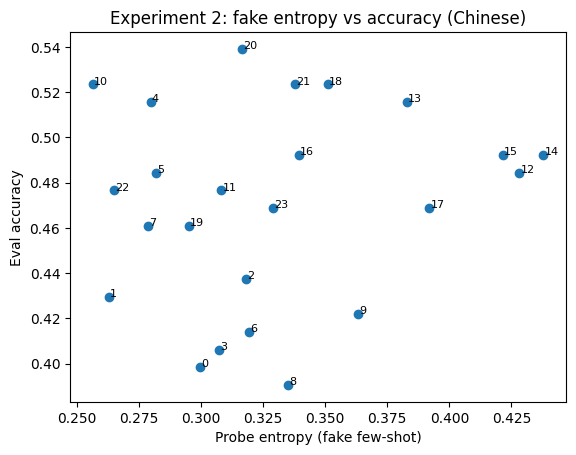

In [ ]:
# 实验 2 - Step 3: fake 熵 与 原来的 accuracy 之间的 Spearman 相关

!pip install -q scipy
from scipy.stats import spearmanr

rho_fake, pval_fake = spearmanr(ents_fake, accs)
print("Spearman (fake entropy vs accuracy): rho =", rho_fake, ", p-value =", pval_fake)

# 仍然以 baseline = 所有 prompt 的平均 accuracy
baseline_acc = float(accs.mean())

K = 4  # 你可以调整 K
topK_high_idx_fake = np.argsort(ents_fake)[::-1][:K]  # 熵最高的 K 个（按论文原本方向）
topK_low_idx_fake  = np.argsort(ents_fake)[:K]        # 熵最低的 K 个（反方向）

high_avg_acc_fake = float(accs[topK_high_idx_fake].mean())
low_avg_acc_fake  = float(accs[topK_low_idx_fake].mean())

print("\n★★★★ Experiment 2 (fake few-shot) ★★★★")
print("Baseline avg acc:                 ", baseline_acc)
print("Top-K highest fake entropy acc:   ", high_avg_acc_fake, " (Δ =", high_avg_acc_fake - baseline_acc, ")")
print("Top-K lowest  fake entropy acc:   ", low_avg_acc_fake,  " (Δ =", low_avg_acc_fake  - baseline_acc, ")")

# 可选：画散点图对比 fake 熵 与 accuracy
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(ents_fake, accs)
for i in range(len(ents_fake)):
    plt.text(ents_fake[i] + 0.0005, accs[i], str(i), fontsize=8)

plt.xlabel("Probe entropy (fake few-shot)")
plt.ylabel("Eval accuracy")
plt.title("Experiment 2: fake entropy vs accuracy (Chinese)")
plt.show()


# 对比英文版本

In [ ]:
# 实验 3-A: English SST-2 with GPT2

!pip install -q transformers datasets accelerate sentencepiece scipy

import math
import numpy as np
from itertools import permutations

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name_en = "gpt2"      # standard English GPT-2

n_shot_en = 4
n_probe_en = 16
n_eval_en = 128
max_comment_tokens_en = 190

np.random.seed(1)
torch.manual_seed(1)

print("Device:", device)


Device: cuda


In [ ]:
# Load English GPT-2
tokenizer_en = AutoTokenizer.from_pretrained(model_name_en)
model_en = AutoModelForCausalLM.from_pretrained(model_name_en).to(device)
model_en.eval()

# GPT-2 has no pad token; sometimes it's convenient to set it = eos
if tokenizer_en.pad_token is None:
    tokenizer_en.pad_token = tokenizer_en.eos_token

print("English tokenizer & model loaded.")

# Load SST-2 dataset
sst2 = load_dataset("glue", "sst2")
train_en = sst2["train"]
val_en   = sst2["validation"]

print(train_en)
print(val_en[:3])


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

English tokenizer & model loaded.


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})
{'sentence': ["it 's a charming and often affecting journey . ", 'unflinchingly bleak and desperate ', 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . '], 'label': [1, 0, 1], 'idx': [0, 1, 2]}


In [ ]:
# label id -> English label word
id2label_word_en = {
    0: "bad",
    1: "good",
}

def truncate_text_en(text, max_tokens=190):
    """
    Truncate text by token length and decode back to string.
    """
    ids = tokenizer_en.encode(text, add_special_tokens=False)
    if len(ids) > max_tokens:
        ids = ids[:max_tokens]
    return tokenizer_en.decode(ids, clean_up_tokenization_spaces=False)

def select_few_shot_examples_en(train_split, n_pos=2, n_neg=2, seed=42):
    """
    Select 2 positive + 2 negative examples from SST-2 train set.
    """
    pos_examples = [ex for ex in train_split if ex["label"] == 1]
    neg_examples = [ex for ex in train_split if ex["label"] == 0]

    rng = np.random.default_rng(seed)
    pos_idx = rng.choice(len(pos_examples), size=n_pos, replace=False)
    neg_idx = rng.choice(len(neg_examples), size=n_neg, replace=False)

    few_shot = []
    for i in pos_idx:
        few_shot.append({"text": pos_examples[i]["sentence"], "label": 1})
    for i in neg_idx:
        few_shot.append({"text": neg_examples[i]["sentence"], "label": 0})
    return few_shot

few_shot_examples_en = select_few_shot_examples_en(train_en, n_pos=2, n_neg=2, seed=1)
assert len(few_shot_examples_en) == n_shot_en

print("Few-shot examples (English):")
for i, ex in enumerate(few_shot_examples_en, start=1):
    print(f"[{i}] label={id2label_word_en[ex['label']]}")
    print(truncate_text_en(ex["text"])[:80], "...\n")


Few-shot examples (English):
[1] label=good
life-altering  ...

[2] label=good
odd purity  ...

[3] label=bad
is a smorgasbord of soliloquies about nothing delivered by the former mr. drew b ...

[4] label=bad
rigid  ...



In [ ]:
# All permutations of 4 examples
prompt_orders_en = list(permutations(range(n_shot_en), n_shot_en))
num_prompts_en = len(prompt_orders_en)
print(f"Number of candidate prompts (English): {num_prompts_en}")

def build_probe_and_eval_en(val_split, n_probe=16, n_eval=128, seed=123):
    """
    Shuffle val split and build probe / eval subsets.
    """
    shuffled = val_split.shuffle(seed=seed)
    probe = shuffled.select(range(min(n_probe, len(shuffled))))
    eval_part = shuffled.select(
        range(
            min(n_probe, len(shuffled)),
            min(n_probe + n_eval, len(shuffled)),
        )
    )
    return probe, eval_part

probe_ds_en, eval_ds_en = build_probe_and_eval_en(val_en, n_probe=n_probe_en, n_eval=n_eval_en, seed=1)
print(f"Probe size (en): {len(probe_ds_en)}, Eval size (en): {len(eval_ds_en)}")


Number of candidate prompts (English): 24
Probe size (en): 16, Eval size (en): 128


In [ ]:
# Pre-compute label tokens and check single token
label_tokens_en = {}
for lid, word in id2label_word_en.items():
    ids = tokenizer_en.encode(word, add_special_tokens=False)
    assert len(ids) == 1, f"Label word {word} is not single token: {ids}"
    label_tokens_en[lid] = ids[0]

print("Label -> token id (en):", label_tokens_en)

def build_prompt_text_en(demo_order, query_text):
    """
    Build English prompt string:
      Review: <demo_text>
      Sentiment: good/bad

      Review: <query_text>
      Sentiment:
    """
    parts = []
    for idx in demo_order:
        ex = few_shot_examples_en[idx]
        label_word = id2label_word_en[ex["label"]]
        demo_text = truncate_text_en(ex["text"], max_comment_tokens_en)
        parts.append(f"Review: {demo_text}\nSentiment: {label_word}\n\n")
    query_text = truncate_text_en(query_text, max_comment_tokens_en)
    parts.append(f"Review: {query_text}\nSentiment: ")
    return "".join(parts)

# Quick preview
tmp_order_en = prompt_orders_en[0]
tmp_text_en = eval_ds_en[0]["sentence"]
print(build_prompt_text_en(tmp_order_en, tmp_text_en)[:300])


Label -> token id (en): {0: 14774, 1: 11274}
Review: life-altering 
Sentiment: good

Review: odd purity 
Sentiment: good

Review: is a smorgasbord of soliloquies about nothing delivered by the former mr. drew barrymore . 
Sentiment: bad

Review: rigid 
Sentiment: bad

Review: not really bad so much as distasteful : we need kidnapping suspense 


In [ ]:
@torch.no_grad()
def get_label_probs_en(prompt_prefix):
    """
    Compute P(label | prompt_prefix) for labels in {0=bad, 1=good}.
    Return: np.array [2] -> [p_bad, p_good]
    """
    log_scores = []
    for lid in [0, 1]:
        label_word = id2label_word_en[lid]
        text = prompt_prefix + label_word
        input_ids = tokenizer_en.encode(text, add_special_tokens=False, return_tensors="pt")
        if input_ids.size(1) > 1024:
            input_ids = input_ids[:, -1024:]
        input_ids = input_ids.to(device)

        outputs = model_en(input_ids)
        logits = outputs.logits
        last_logits = logits[0, -1, :]
        log_probs = torch.log_softmax(last_logits, dim=-1)
        log_scores.append(log_probs[label_tokens_en[lid]].item())

    max_log = max(log_scores)
    exps = [math.exp(s - max_log) for s in log_scores]
    s = sum(exps)
    probs = [e / s for e in exps]  # [p_bad, p_good]
    return np.array(probs, dtype=np.float32)

# quick test
test_prompt_en = build_prompt_text_en(prompt_orders_en[0], eval_ds_en[0]["sentence"])
print("Test probs (en):", get_label_probs_en(test_prompt_en))


Test probs (en): [0.7834029  0.21659708]


In [ ]:
true_probs_en = {pid: [] for pid in range(num_prompts_en)}
fake_probs_en = {pid: [] for pid in range(num_prompts_en)}
true_labels_en = []

print("🚀 Start evaluating all permutations (English)...")

# 1) eval set
for ex in eval_ds_en:
    text = ex["sentence"]
    label = int(ex["label"])
    true_labels_en.append(label)

    for pid, order in enumerate(prompt_orders_en):
        prompt_prefix = build_prompt_text_en(order, text)
        probs = get_label_probs_en(prompt_prefix)
        true_probs_en[pid].append(probs)

true_labels_en = np.array(true_labels_en, dtype=np.int64)

# 2) probe set
for ex in probe_ds_en:
    text = ex["sentence"]
    for pid, order in enumerate(prompt_orders_en):
        prompt_prefix = build_prompt_text_en(order, text)
        probs = get_label_probs_en(prompt_prefix)
        fake_probs_en[pid].append(probs)

print("Done (English).")


🚀 Start evaluating all permutations (English)...
Done (English).



★★★★ Experiment 3-A: English SST-2 + GPT2 ★★★★
Number of permutations: 24
Probe size: 16 , Eval size: 128
-------------------------------------------
Baseline avg acc:                 0.458984375
Top-K highest entropy avg acc:    0.44921875  (Δ = -0.009765625 )
Top-K lowest  entropy avg acc:    0.4609375  (Δ = 0.001953125 )
-------------------------------------------
Baseline ensemble acc:            0.4609375
Top-K highest entropy ens acc:    0.4296875  (Δ = -0.03125 )
Top-K lowest  entropy ens acc:    0.4609375  (Δ = 0.0 )
-------------------------------------------
Spearman (entropy vs acc): rho = -0.06756881885646525 , p-value = 0.753744376313275


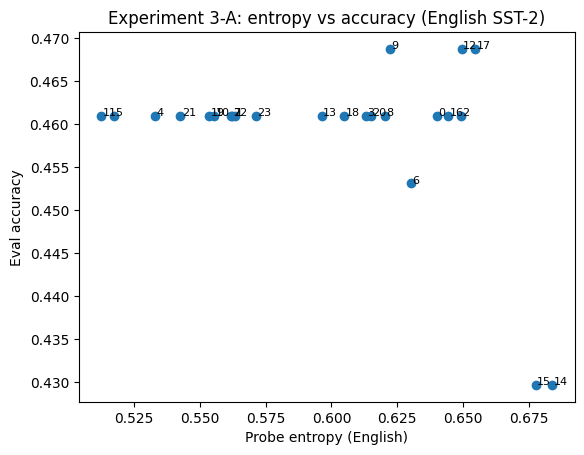

In [ ]:
def simple_entropy_en(p):
    p = np.asarray(p, dtype=np.float64)
    p = p / (p.sum() + 1e-12)
    return float(-np.sum(p * np.log(p + 1e-12)))

accs_en = []
ents_en = []

for pid in range(num_prompts_en):
    tp = np.stack(true_probs_en[pid], axis=0)   # [N_eval_en, 2]
    fp = np.stack(fake_probs_en[pid], axis=0)   # [N_probe_en, 2]

    preds = np.argmax(tp, axis=1)
    acc = np.mean(preds == true_labels_en)
    accs_en.append(acc)

    avg_p = np.mean(fp, axis=0)
    ent = simple_entropy_en(avg_p)
    ents_en.append(ent)

accs_en = np.array(accs_en)
ents_en = np.array(ents_en)

baseline_acc_en = float(accs_en.mean())
K_en = 4

# 按熵从大到小（论文原本方向）
topK_high_idx_en = np.argsort(ents_en)[::-1][:K_en]
topK_low_idx_en  = np.argsort(ents_en)[:K_en]

high_avg_acc_en = float(accs_en[topK_high_idx_en].mean())
low_avg_acc_en  = float(accs_en[topK_low_idx_en].mean())

# ensemble 版本
all_true_probs_en = np.stack(
    [np.stack(true_probs_en[pid], axis=0) for pid in range(num_prompts_en)],
    axis=0
)  # [24, N_eval_en, 2]

baseline_probs_en = all_true_probs_en.mean(axis=0)
baseline_preds_en = baseline_probs_en.argmax(axis=1)
baseline_ens_acc_en = (baseline_preds_en == true_labels_en).mean()

topK_high_probs_en = all_true_probs_en[topK_high_idx_en].mean(axis=0)
topK_high_preds_en = topK_high_probs_en.argmax(axis=1)
topK_high_ens_acc_en = (topK_high_preds_en == true_labels_en).mean()

topK_low_probs_en = all_true_probs_en[topK_low_idx_en].mean(axis=0)
topK_low_preds_en = topK_low_probs_en.argmax(axis=1)
topK_low_ens_acc_en = (topK_low_preds_en == true_labels_en).mean()

rho_en, pval_en = spearmanr(ents_en, accs_en)

print("\n★★★★ Experiment 3-A: English SST-2 + GPT2 ★★★★")
print("Number of permutations:", num_prompts_en)
print("Probe size:", len(probe_ds_en), ", Eval size:", len(eval_ds_en))
print("-------------------------------------------")
print("Baseline avg acc:                ", baseline_acc_en)
print("Top-K highest entropy avg acc:   ", high_avg_acc_en, " (Δ =", high_avg_acc_en - baseline_acc_en, ")")
print("Top-K lowest  entropy avg acc:   ", low_avg_acc_en,  " (Δ =", low_avg_acc_en  - baseline_acc_en, ")")
print("-------------------------------------------")
print("Baseline ensemble acc:           ", baseline_ens_acc_en)
print("Top-K highest entropy ens acc:   ", topK_high_ens_acc_en, " (Δ =", topK_high_ens_acc_en - baseline_ens_acc_en, ")")
print("Top-K lowest  entropy ens acc:   ", topK_low_ens_acc_en,  " (Δ =", topK_low_ens_acc_en  - baseline_ens_acc_en, ")")
print("-------------------------------------------")
print("Spearman (entropy vs acc): rho =", rho_en, ", p-value =", pval_en)

# 散点图
plt.figure()
plt.scatter(ents_en, accs_en)
for i in range(len(ents_en)):
    plt.text(ents_en[i] + 0.0005, accs_en[i], str(i), fontsize=8)
plt.xlabel("Probe entropy (English)")
plt.ylabel("Eval accuracy")
plt.title("Experiment 3-A: entropy vs accuracy (English SST-2)")
plt.show()
